# <center> Global Fashion Group Data Science Challenge

__Note__: My focus in this challenge is to demonstrate project structuring, coding and data science fundamentals while optimising for simplicity over accuracy. 
<br>Hence please do not expect to find a kaggle-like deep-dive into the data and model tuning. 
<br>The project pipelines was built using __Kedro__ and it allows running of entire pipelines, containerizing through docker and scheduling through airflow. 
<br>Instructions to run the kedro pipeline have been shared with you.
<br> - Karthik :)

## 1. Executive Summary

A quick dive into the data revealed that the coupon discount applied column may have errors as it had negative values, values that are larger then 1, and extremely large values. Similarly the revenue column also had negative value and large values. A quick fix was to subset the data to include rows where coupon discount applied was between 0 and 1. This solved most issues except for extremely large revenues (possibly customer was a reselling retailer).
<br>The data provided was unlabelled so my (simple but not technically correct) approach was to "cluster-then-classify". A clustering model was built to generate gender labels which i assumed to be ground-truth. 
<br>Since the clustering model has to return 2 clusters that proxies gender, the features has to extremely gender discriminatory. Hence i engineered several features of proportions of female items based on different item categories amongst other general features.
A 2-layer neural network was trained to then predict predict gender. 
<br>This resulted in a decent test set accuracy around __99%__. 
<br>To make predictions more robust, i would require item level data and i would use features such as the name of the item, name of customer etc. I would also choose not to do a "cluster-then-classify" approach as the classifier would only be approximating the cluster boundaries from the clustering model. The technically correct approach would be to cluster only. Since the requirements from the challenge prefers a deep learning approach, i will go with an autoencoder approach to infer gender labels.

## 2.0 Workflow

In [7]:
from IPython.display import Image, display
display(Image(filename='https://github.com/penguinpompom/gfg/blob/master/data/08_reporting/pipeline.PNG', embed=True))

### 2.0.0 Import relevant libraries, decypt and read json into dataframe

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical 

from gfg.nodes.data_engineering import unzip

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('float_format', '{:f}'.format)
pd.options.mode.chained_assignment = None 

In [2]:
np.random.seed(42)

In [3]:
json = unzip('./data/01_raw/test_data.zip')

In [4]:
df = pd.read_json(json[0], orient = 'records')

In [5]:
print('No. of rows: ', df.shape[0])
print('No. of columns: ', df.shape[1])

No. of rows:  191287
No. of columns:  33


In [6]:
df.head()

,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,sprt_items,msite_orders,desktop_orders,android_orders,ios_orders,work_orders,home_orders,parcelpoint_orders,coupon_discount_applied,revenue,customer_id
0,2783,1487,N,2,5,0,0,2,1,0,5,0,0,0,4,1,0,0,3,0,0,2,0,0,2,0,0,0,0,0,0.000000,468.800000,3017000653.510000
1,2772,1296,N,1,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0.009100,109.090000,3017108284.782000
2,2773,1929,N,4,4,0,0,2,1,0,4,0,0,4,0,0,1,2,0,1,0,0,0,0,4,0,0,0,0,0,0.000000,448.540000,3017125582.665000
3,2767,6,Y,23,36,3,0,3,3,13,24,0,12,28,1,7,8,11,0,2,1,4,0,8,2,0,13,0,21,0,0.172300,1872.810000,3017185164.262000
4,1430,826,N,2,6,0,0,2,1,0,6,0,0,0,6,0,0,0,2,0,3,1,0,0,2,0,0,0,2,0,0.003300,301.170000,3017192852.210000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191287 entries, 0 to 191286
Data columns (total 33 columns):
days_since_first_order      191287 non-null int64
days_since_last_order       191287 non-null int64
is_newsletter_subscriber    191287 non-null object
orders                      191287 non-null int64
items                       191287 non-null int64
returns                     191287 non-null int64
different_addresses         191287 non-null int64
shipping_addresses          191287 non-null int64
devices                     191287 non-null int64
vouchers                    191287 non-null int64
cc_payments                 191287 non-null int64
paypal_payments             191287 non-null int64
afterpay_payments           191287 non-null int64
female_items                191287 non-null int64
male_items                  191287 non-null int64
unisex_items                191287 non-null int64
wapp_items                  191287 non-null int64
wftw_items                  191287 non

Only 1 categorical variable, __is_newsletter_subscriber__, and there are no NaNs. Thats a great start!

In [8]:
df.describe()

,days_since_first_order,days_since_last_order,orders,items,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,sprt_items,msite_orders,desktop_orders,android_orders,ios_orders,work_orders,home_orders,parcelpoint_orders,coupon_discount_applied,revenue,customer_id
count,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000,191287.000000
mean,2325.415344,862.390832,10.841887,24.544668,7.075745,1.258392,2.412438,1.645747,3.394993,13.190337,7.891749,2.942129,19.975942,3.759853,0.808874,13.846707,3.946588,2.346830,1.745932,0.782965,0.862097,0.238532,2.732941,5.700529,0.227517,2.180901,1.203485,6.038685,0.101471,1321.704274,1515.276901,3387435965.418024
std,382.012579,832.876737,19.191299,50.868840,25.923825,8.920020,4.493934,0.734939,7.428651,34.672078,24.887787,13.186908,45.617789,11.935671,2.016606,34.962568,8.023221,8.773565,4.587027,2.343804,2.422466,0.916521,7.253788,11.975780,2.096664,8.206619,5.061593,12.875926,1.425184,39053.560967,3508.433432,209410344.928336
min,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-155.978400,-1.130000,3016869958.394000
25%,2271.000000,92.000000,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004800,140.840000,3202563693.392500
50%,2414.000000,544.000000,4.000000,8.000000,1.000000,0.000000,2.000000,1.000000,1.000000,3.000000,1.000000,0.000000,5.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.055200,443.100000,3398474711.283000
75%,2526.000000,1659.000000,12.000000,25.000000,4.000000,0.000000,3.000000,2.000000,4.000000,11.000000,6.000000,0.000000,19.000000,3.000000,1.000000,12.000000,4.000000,1.000000,2.000000,1.000000,1.000000,0.000000,3.000000,6.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.146600,1477.225000,3567304932.343500
max,2813.000000,2329.000000,1289.000000,3020.000000,2022.000000,1996.000000,1122.000000,4.000000,1135.000000,2928.000000,1670.000000,615.000000,2150.000000,1115.000000,75.000000,1728.000000,493.000000,947.000000,266.000000,206.000000,151.000000,44.000000,373.000000,1275.000000,244.000000,357.000000,223.000000,496.000000,290.000000,5798000.000000,205655.020000,3801194413.354000


A couple of things standout as a potential problem:
1. __coupon_discount_applied__ has negative values when it shouldnt. Has astronomically high rates.5798000???NANI???
2. __revenue__ has negative values when it shouldnt.

### 2.1.0 Validation 

#### 2.1.1 Check for duplicate customer ids

In [9]:
df['customer_id'] = df['customer_id'].astype(str)

In [10]:
df[df.duplicated(subset = 'customer_id')]

,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,sprt_items,msite_orders,desktop_orders,android_orders,ios_orders,work_orders,home_orders,parcelpoint_orders,coupon_discount_applied,revenue,customer_id


No duplicate customer ids.

#### 2.1.2 Check coupon_discount_applied

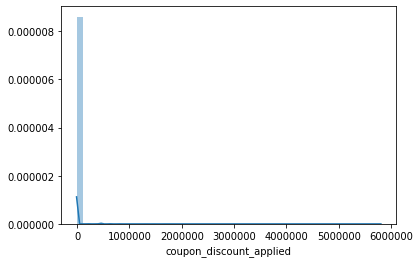

In [11]:
sns.distplot(df['coupon_discount_applied'])

In [12]:
df[df['coupon_discount_applied'] > 1]

,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,sprt_items,msite_orders,desktop_orders,android_orders,ios_orders,work_orders,home_orders,parcelpoint_orders,coupon_discount_applied,revenue,customer_id
17,2782,1518,N,1,2,2,2,1,1,1,0,2,0,2,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,9.163800,9.820000,3017940505.153
799,2528,2255,N,2,3,2,0,1,1,1,1,0,0,2,1,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,1.999500,45.410000,3050306766.233
886,2618,1906,N,1,4,0,4,1,1,1,4,0,0,4,0,0,2,1,0,1,0,0,0,1,0,0,0,0,0,0,1.000100,72.620000,3054031577.039
972,2596,2288,N,1,1,0,1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,7.884900,8.180000,3056897259.656
1501,2574,1840,N,1,2,0,0,1,1,1,0,2,0,0,2,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,2.876500,12.640000,3075594349.192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190877,2202,2202,N,1,1,0,0,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1.669100,27.230000,3739915701.833
190911,2066,1892,N,2,2,1,0,1,1,2,1,0,0,2,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,30.158600,4.520000,3741232262.928
190923,2177,2177,N,1,1,0,0,1,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,381800.000000,0.000000,3741730057.561
191155,2224,2224,Y,1,1,0,0,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,15.150700,4.500000,3702016040.18


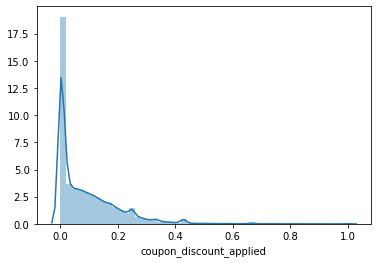

In [13]:
sns.distplot(df[(df['coupon_discount_applied'] < 1) & (df['coupon_discount_applied'] >= 0)]['coupon_discount_applied'])

In [14]:
df[(df['coupon_discount_applied'] < 1) & (df['coupon_discount_applied'] >= 0)].shape

(189935, 33)

In [15]:
df2 = df[(df['coupon_discount_applied'] < 1) & (df['coupon_discount_applied'] >= 0)]

#### 2.1.3 Check revenue

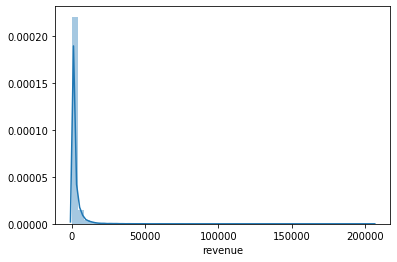

In [16]:
sns.distplot(df2['revenue'])

In [17]:
df2['revenue'].describe()

count   189935.000000
mean      1525.511376
std       3518.411926
min          0.000000
25%        145.280000
50%        449.750000
75%       1491.755000
max     205655.020000
Name: revenue, dtype: float64

Both __revenue__ and __coupon_discount_applied__ looks reasonable now.

### 2.2.0 Feature exploration

In [42]:
list(df2.columns)

['days_since_first_order',
 'days_since_last_order',
 'orders',
 'items',
 'returns',
 'different_addresses',
 'shipping_addresses',
 'devices',
 'vouchers',
 'cc_payments',
 'paypal_payments',
 'afterpay_payments',
 'female_items',
 'male_items',
 'unisex_items',
 'wapp_items',
 'wftw_items',
 'mapp_items',
 'wacc_items',
 'macc_items',
 'mftw_items',
 'sprt_items',
 'msite_orders',
 'desktop_orders',
 'android_orders',
 'ios_orders',
 'work_orders',
 'home_orders',
 'parcelpoint_orders',
 'coupon_discount_applied',
 'revenue',
 'customer_id',
 'X_days_active',
 'X_order_per_day',
 'X_items_per_order',
 'X_avg_rev_per_items_per_order',
 'X_returns_per_order',
 'X_vouchers_per_order',
 'X_female_items_per_item',
 'X_waap_per_app',
 'X_wacc_per_acc',
 'X_wftw_per_ftw',
 'labels',
 'newsletter_N',
 'newsletter_Y']

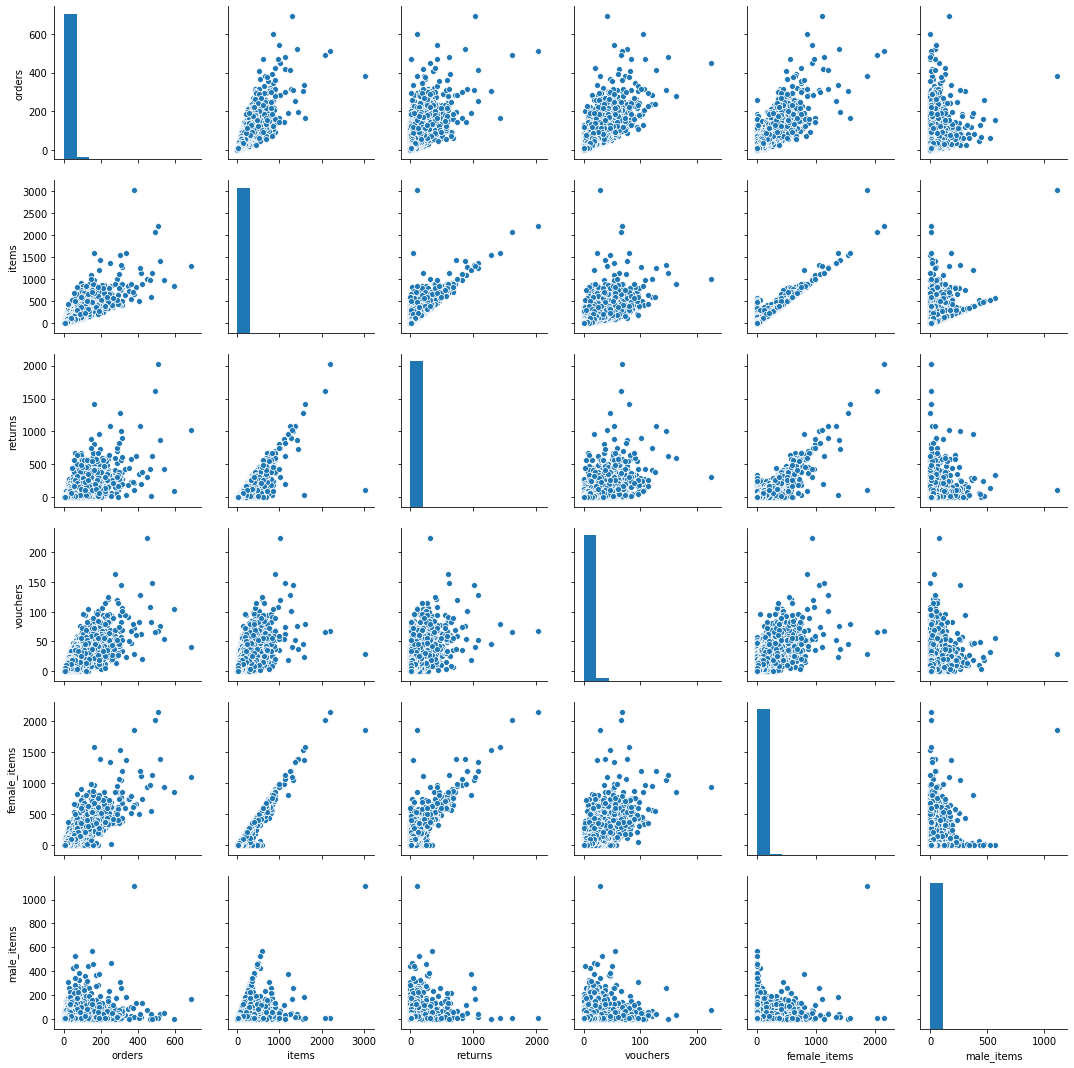

In [45]:
sns.pairplot(df2[['orders',
                 'items',
                 'returns',
                 'vouchers',
                 'female_items',
                 'male_items']])

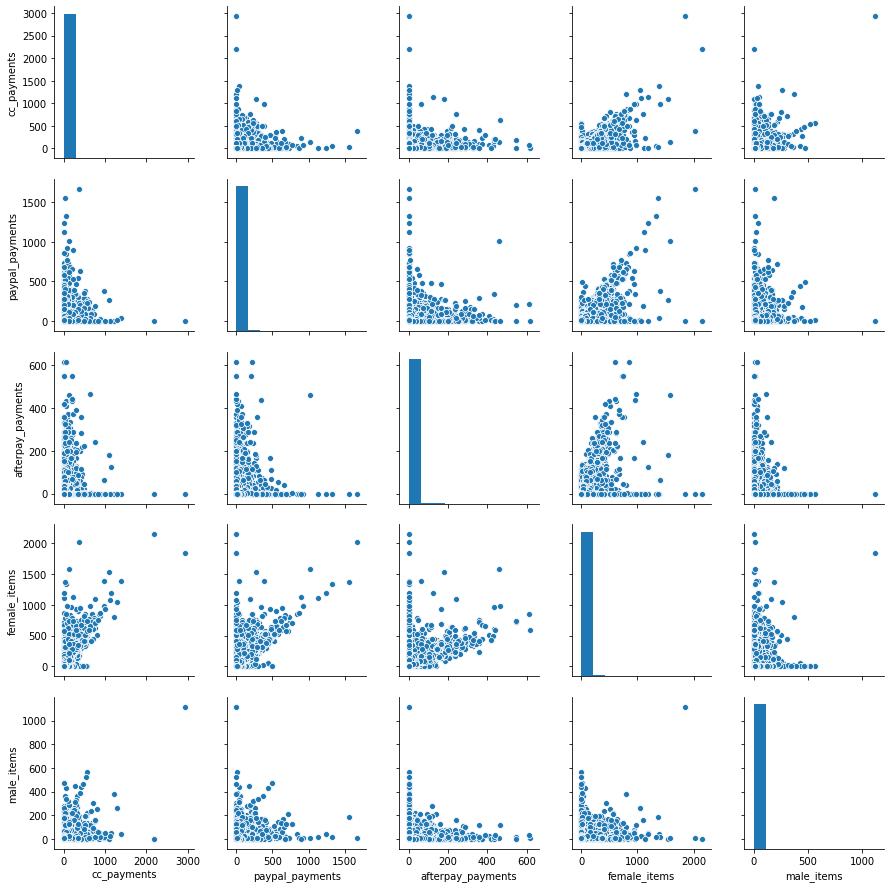

In [46]:
sns.pairplot(df2[['cc_payments',
                  'paypal_payments',
                  'afterpay_payments',
                  'female_items',
                  'male_items']])

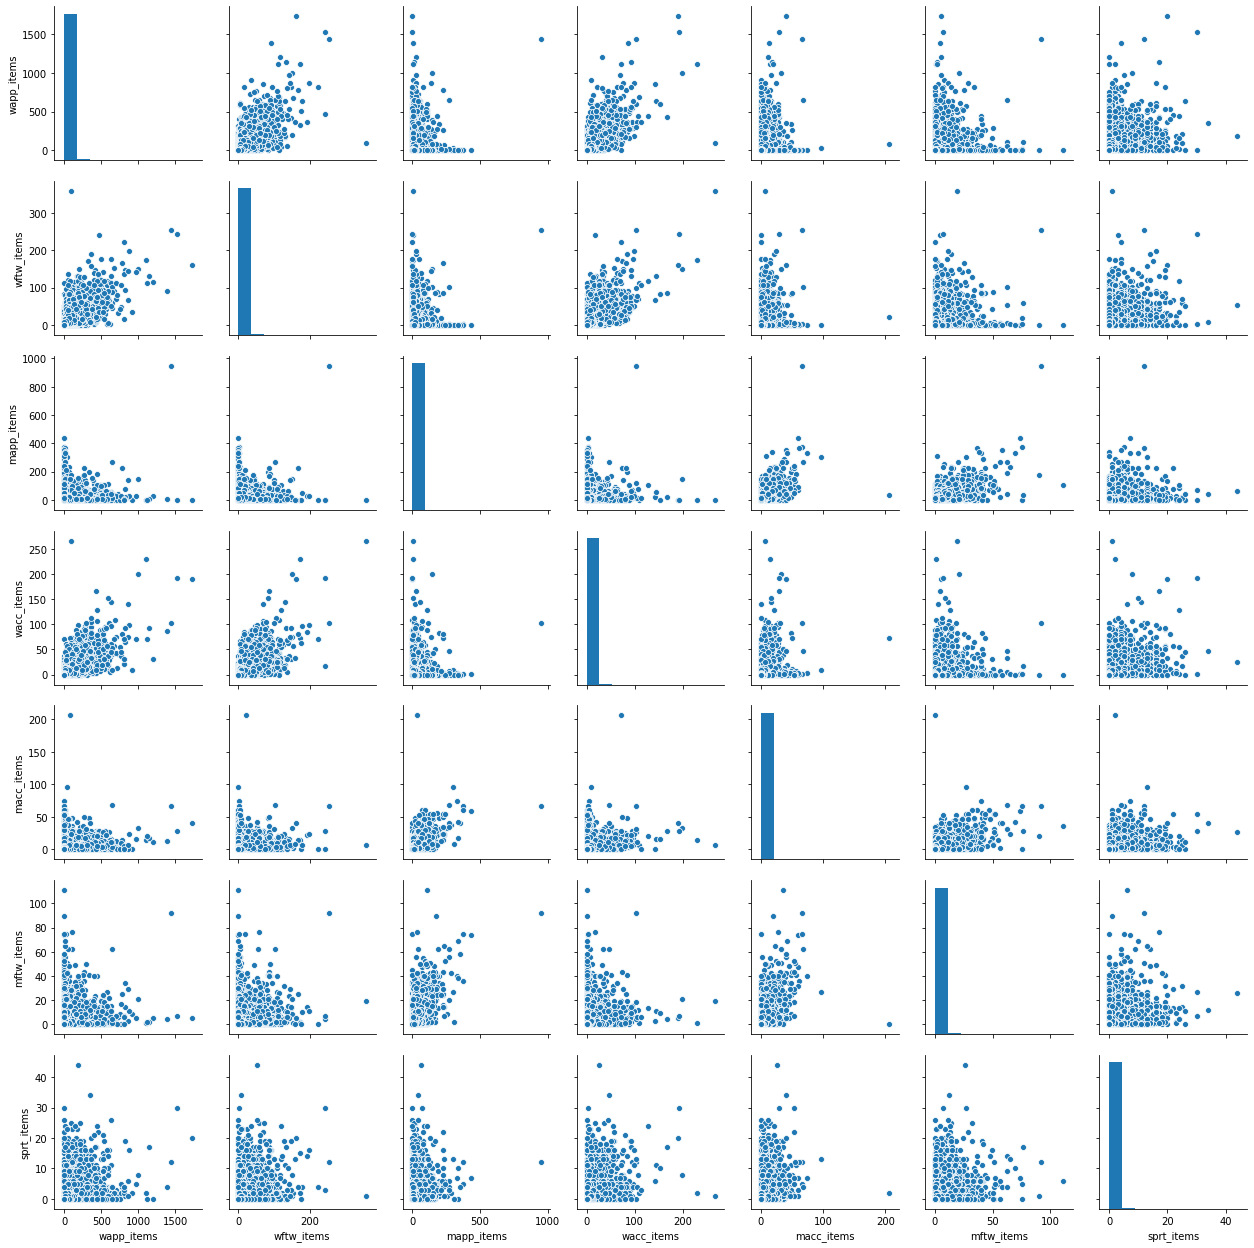

In [47]:
sns.pairplot(df2[['wapp_items',
                 'wftw_items',
                 'mapp_items',
                 'wacc_items',
                 'macc_items',
                 'mftw_items',
                 'sprt_items']])

### 2.3.0 Feature Engineering

For the clustering model to return clusters that are gender specific, the features passed also have to be extremely gender discriminatory. Hence i will be creating several gender specific features:
1. __X_female_items_per_item:__ Proportion of female items bought. 
2. __X_waap_per_app:__ Proportion of women's apparels bought.
3. __X_wacc_per_acc:__ Proportion of women's accessories bought.
4. __X_wftw_per_ftw:__ Proportion of women's footwear bought.

and some gender neutral features that could seperate gender behaviours:
1. __X_days_active:__ Number of days active.
2. __X_order_per_day:__ Number of orders per day i.e. Average Order frequency.
3. __X_items_per_order:__ Number of items per order i.e. Average Order size.
4. __X_avg_rev_per_items_per_order:__ Average revenue per item per order.
5. __X_returns_per_order:__ Average returns per order.
6. __X_vouchers_per_order:__ Average vouchers used per order.

In [18]:
df2['X_days_active'] = df2['days_since_first_order'] - df2['days_since_last_order']

df2['X_order_per_day'] = df2['orders'] / df2['X_days_active']
df2['X_order_per_day'] = df2['X_order_per_day'].replace([np.inf, -np.inf], 0)

df2['X_items_per_order'] = df2['items'] / df2['orders']
df2['X_avg_rev_per_items_per_order'] = df2['revenue'] / df2['X_items_per_order']
df2['X_returns_per_order'] = df2['returns'] / df2['orders']
df2['X_vouchers_per_order'] = df2['vouchers'] / df2['orders']
df2['X_female_items_per_item'] = df2['female_items'] / df2['items']

df2['X_waap_per_app'] = df2['wapp_items'] / (df2['wapp_items'] + df2['mapp_items'])
df2['X_wacc_per_acc'] = df2['wacc_items'] / (df2['wacc_items'] + df2['macc_items'])
df2['X_wftw_per_ftw'] = df2['wftw_items'] / (df2['wftw_items'] + df2['mftw_items'])

2019-11-10 02:20:21,445 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


In [19]:
df2 = df2.fillna(0)

### 2.4.0 Scale data points

In [20]:
asis_features = [x for x in df2.columns if x not in ['customer_id', 'is_newsletter_subscriber']]
eng_features = [x for x in list(df2.columns) if x.startswith('X_')]
features = asis_features + eng_features
X = df2[features]

In [21]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### 2.5.0 Cluster to create inferred gender labels

In [22]:
kmeans = KMeans(n_clusters=2, 
                max_iter= 1000, 
                algorithm = 'auto', 
                random_state = 42)
kmeans.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [23]:
labels = kmeans.predict(X_scaled)
df2['labels'] = labels
df2['labels'] = df2['labels'].map({0: 1, 1: 0})

In [24]:
df2['labels'].value_counts(normalize = True)

1   0.535399
0   0.464601
Name: labels, dtype: float64

#### 2.5.1 Visualise clusters

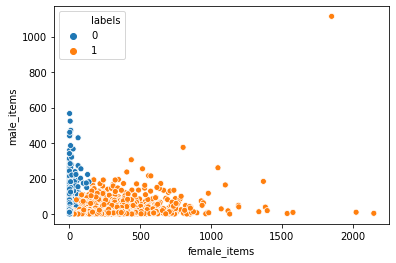

In [25]:
sns.scatterplot(x = 'female_items', y = 'male_items', hue = 'labels', data=df2)

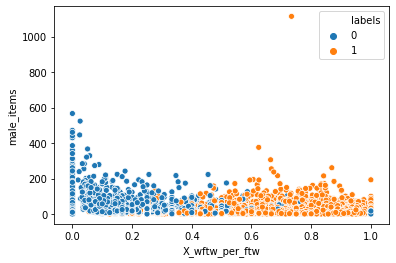

In [26]:
sns.scatterplot(x = 'X_wftw_per_ftw', y = 'male_items', hue = 'labels', data=df2)

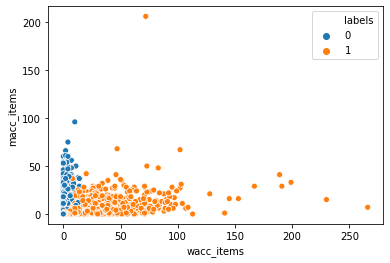

In [27]:
sns.scatterplot(x = 'wacc_items', y = 'macc_items', hue = 'labels', data=df2)

Clusters seem reasonable well defined given current dataset and time limitations. We shall assume the "inferred gender" labels are ground truth now.

### 2.6.0 Prepare data set for classification

#### 2.6.1 One-hot encode is_newsletter_subscriber

In [28]:
df2 = (df2.join(pd.get_dummies(df2['is_newsletter_subscriber'], 
                               prefix = 'newsletter'))
       .drop(columns = 'is_newsletter_subscriber'))

#### 2.6.2 Train-test split and scale

In [29]:
df3 = df2.set_index('customer_id')

In [30]:
X = df3.loc[:,df3.columns != 'labels']
y = df3['labels']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [32]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [33]:
print(X_train_norm.shape)
print(X_test_norm.shape)
print(y_train.shape)
print(y_test.shape)

(151948, 43)
(37987, 43)
(151948,)
(37987,)


#### 2.6.3 Define model architecture

In [34]:
model = Sequential()
model.add(Dense(8, activation='relu', input_dim = X_train_norm.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam', 
              metrics=['accuracy'])

#### 2.6.4 Train model

In [35]:
model.fit(X_train_norm, 
          y_train, 
          epochs = 20, 
          batch_size = 100,
          validation_split = 0.2,
          verbose = 2)

Train on 121558 samples, validate on 30390 samples
Epoch 1/20
 - 1s - loss: 0.1322 - accuracy: 0.9531 - val_loss: 0.0299 - val_accuracy: 0.9888
Epoch 2/20
 - 1s - loss: 0.0246 - accuracy: 0.9908 - val_loss: 0.0198 - val_accuracy: 0.9937
Epoch 3/20
 - 1s - loss: 0.0169 - accuracy: 0.9943 - val_loss: 0.0144 - val_accuracy: 0.9939
Epoch 4/20
 - 1s - loss: 0.0132 - accuracy: 0.9954 - val_loss: 0.0109 - val_accuracy: 0.9974
Epoch 5/20
 - 1s - loss: 0.0112 - accuracy: 0.9963 - val_loss: 0.0092 - val_accuracy: 0.9973
Epoch 6/20
 - 1s - loss: 0.0097 - accuracy: 0.9966 - val_loss: 0.0079 - val_accuracy: 0.9976
Epoch 7/20
 - 1s - loss: 0.0086 - accuracy: 0.9971 - val_loss: 0.0075 - val_accuracy: 0.9976
Epoch 8/20
 - 1s - loss: 0.0078 - accuracy: 0.9974 - val_loss: 0.0068 - val_accuracy: 0.9978
Epoch 9/20
 - 1s - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.0065 - val_accuracy: 0.9981
Epoch 10/20
 - 1s - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.0055 - val_accuracy: 0.9987
Epoch 11/20
 - 1s 

At a glance, fit appears reasonable as val accuracy stabilises around 99%

#### 2.6.5 Evaluate model

In [36]:
predicted = model.predict_classes(X_test_norm)

In [37]:
print('Test Accuracy: ',accuracy_score(y_test, predicted))

Test Accuracy:  0.9982888883038934


[Text(0, 0.5, 'Male'), Text(0, 1.5, 'Female')]

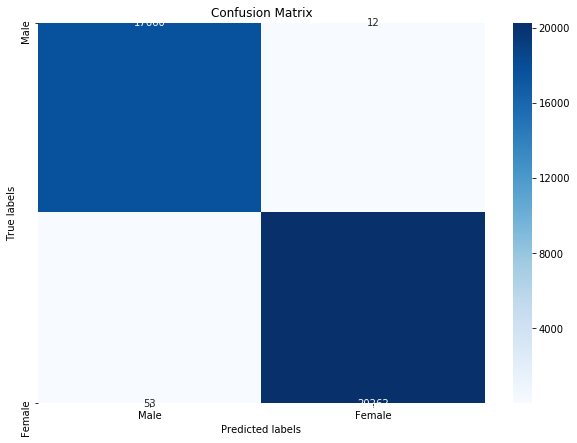

In [38]:
plt.figure(figsize = (10,7))
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, predicted), 
            annot=True, 
            ax = ax,
            fmt = 'g',
            cmap = 'Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['Male', 'Female']) 
ax.yaxis.set_ticklabels(['Male', 'Female'])

### 2.7.0 Score and submit

In [39]:
XX = df2.loc[:, ~df2.columns.isin(['customer_id', 'labels'])]
yy = df2['labels']

y_pred = model.predict_classes(XX)

submission = pd.DataFrame({'customer_id' : df2['customer_id'],
                           'female_flag' : y_pred.reshape((y_pred.shape[0],)),
                           'cluster_labels' : yy})

In [40]:
print('Overall Accuracy: ',accuracy_score(submission['cluster_labels'], submission['female_flag']))

Overall Accuracy:  0.7050148735093584


Extremely large room for improvement.